In [62]:
import numpy as np
import pandas as pd

from scripts.wrangling_funs import read_and_clean_fines_data, pivot_fines_longer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# read in data, remove zero values for price and convert to long format
fines = (
    read_and_clean_fines_data(path="./data/scraped_fines.csv")
    .pipe(pivot_fines_longer)
)

In [72]:
# df showing article next to how often it was referenced.
n_citations = (
    fines
    .value_counts('article_number')
    .reset_index(name='count')
    .sort_values('article_number')
)

## Creating a dataset for Modelling

In [80]:

MIN_CITATIONS = 30
INTEREST_VARS = ['year', 'article_number']

index = ['id', 'total_fine_euro'].extend(INTEREST_VARS)

print(index)

# pivot data
gdpr_model_data = (
    fines
    .assign(
        violated=1,
        total_fine_euro = lambda x: np.log10(x.total_fine_euro),
        year            = lambda x: x.date.dt.year
    )
    .merge(
        n_citations.query(f'count >= {MIN_CITATIONS}'),
        how='inner', left_on='article_number', right_on='article_number'
        )
    .pivot_table(values=['violated'], index=['id', 'total_fine_euro'] + INTEREST_VARS)
    .unstack(level=-1, fill_value=0)
)

# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['A' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = pd.get_dummies(gdpr_model_data.reset_index())

None


In [81]:
gdpr_model_data

,id,total_fine_euro,year,A2,A5,A6,A7,A9,A12,A13,...,A17,A21,A24,A25,A28,A31,A32,A33,A35,A58
0,1,3.972203,2019,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,3.397940,2019,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,4.778151,2019,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,3.903090,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,5.176091,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559,1696,4.095169,2022,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1560,1698,3.301030,2020,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1561,1699,3.397940,2020,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1562,1700,4.301030,2020,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Creating a Dataset for Modelling

In [295]:
# TODO:: return to -> decide to delete
# pivot data
gdpr_model_data = (
    overmin_incidence
    .assign(violated=1, year = lambda x: x.date.dt.year, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .loc[:, ['id','year', 'country', 'total_fine_euro', 'article_number', 'violated']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['A' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

# Regressing Article on Total Fine Price

In [82]:
import statsmodels.api as sm

In [83]:
gdpr_model_data.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
id,1564.0,833.065217,489.528139,1.000000,408.75000,821.500000,1252.250000,1701.000000
total_fine_euro,1564.0,4.026971,1.007934,1.447158,3.30103,3.845098,4.645893,9.079181
year,1564.0,2020.564578,5.120960,1970.000000,2020.00000,2021.000000,2022.000000,2023.000000
A2,1564.0,0.026854,0.161709,0.000000,0.00000,0.000000,0.000000,1.000000
A5,1564.0,0.527494,0.499403,0.000000,0.00000,1.000000,1.000000,1.000000
A6,1564.0,0.350384,0.477243,0.000000,0.00000,0.000000,1.000000,1.000000
A7,1564.0,0.023657,0.152028,0.000000,0.00000,0.000000,0.000000,1.000000
A9,1564.0,0.069054,0.253627,0.000000,0.00000,0.000000,0.000000,1.000000
A12,1564.0,0.111893,0.315335,0.000000,0.00000,0.000000,0.000000,1.000000
A13,1564.0,0.196292,0.397319,0.000000,0.00000,0.000000,0.000000,1.000000


In [85]:
X = gdpr_model_data.drop(columns=["id", "total_fine_euro"])
y = gdpr_model_data.total_fine_euro

mod = sm.OLS(y, X.assign(constant=1).astype('float'))
res = mod.fit()

coefs = pd.concat([res.params, res.conf_int()], axis=1)

coefs.columns = ['estimate', 'ci0', 'ci1']

In [87]:
# make a nice coeficient table for plotting
coefTable = (
    coefs
    .reset_index(names='coef')
    .assign(
        ci_length = lambda x: x.ci1 - x.estimate,
        hits0     = lambda x: (0 > x.ci0) & (0 < x.ci1)
    )
    .loc[lambda x: x.coef != 'constant', ['coef', 'estimate', 'ci_length', 'hits0']]
)

In [88]:
coefTable.head(2)

,coef,estimate,ci_length,hits0
0,year,-0.001622,0.009011,True
1,A2,-0.456740,0.297996,False


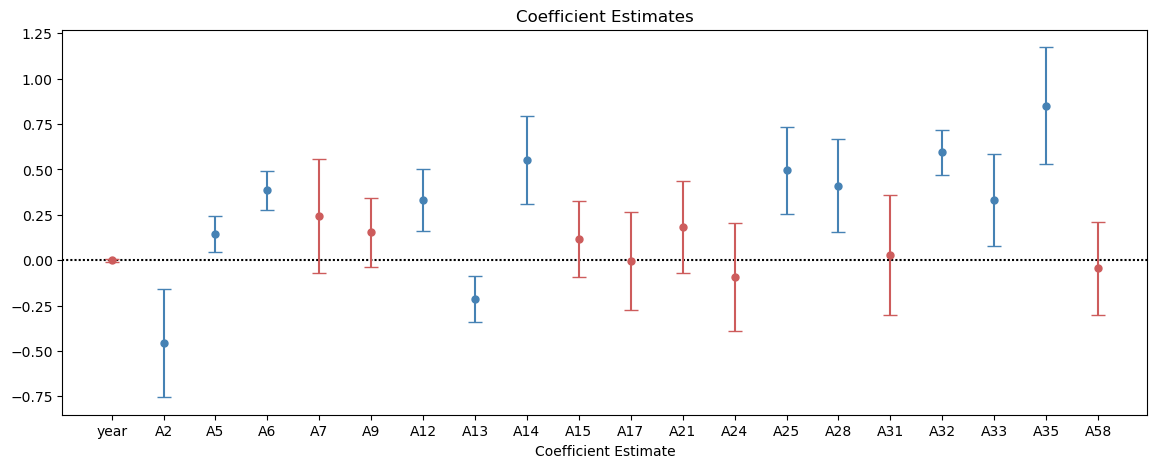

In [94]:
colors = {'True': 'indianred', 'False': 'steelblue'}

fig, ax = plt.subplots(figsize=(14, 5))

ax.axhline(y=0, color="black", linestyle=(0, (1, 1)))
ax.set(ylabel=None, xlabel="Coefficient Estimate", title="Coefficient Estimates", xticks=coefTable.index, xticklabels=coefTable.coef)

for hit_type in np.unique(coefTable.hits0):
    color = colors[str(hit_type)]
    df_subset = coefTable.query(f'hits0 == {hit_type}')
    ax.errorbar(
        df_subset.index, df_subset.estimate, yerr=df_subset.ci_length,
        marker='o', color=color, ls='', ms=5, capsize=5, label=hit_type
    )

plt.show()

In [14]:
# pivot data
gdpr_model_data = (
    only_top_n_highest_fines
    .assign(violated=1, year = lambda x: x.date.dt.year, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .loc[:, ['id','year', 'country', 'total_fine_euro', 'article_number', 'violated']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

In [15]:
# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['article_' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

In [20]:
gdpr_model_data

,id,year,country,total_fine_euro,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,1,2019,Poland,3.972203,1,0,1,1,0,0,0,0,0,0
1,2,2019,Romania,3.397940,1,0,0,0,0,0,0,0,0,0
2,4,2019,Spain,3.903090,0,0,0,0,0,0,0,1,0,0
3,5,2019,Romania,5.176091,0,0,0,0,0,0,0,1,0,0
4,6,2019,Romania,4.301030,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1694,2022,Cyprus,3.176091,1,1,1,0,0,0,0,0,0,0
1196,1697,2023,France,6.716003,0,0,0,0,0,0,0,1,0,0
1197,1698,2020,Malta,3.301030,1,0,0,0,0,0,0,1,0,0
1198,1699,2020,Malta,3.397940,0,0,0,1,0,0,0,0,0,0


In [40]:
with_controller = (
    only_top_n_highest_fines
    .assign(violated=1, year = lambda x: x.date.dt.year)
    .loc[:, ['id', 'date', 'year', 'country', 'total_fine_euro', 'article_number', 'violated', 'controller']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id','date', 'year', 'country', 'total_fine_euro', 'article_number', 'controller'])
    .unstack(level=-2, fill_value=0)
)

# sort out indexing
with_controller.columns = with_controller.columns.droplevel(0)
with_controller.columns.name = None

with_controller.columns = ['article_' + str(col) for col in with_controller.columns]

with_controller = with_controller.reset_index()

NameError: name 'only_top_n_highest_fines' is not defined

In [20]:
top5_fines_per_yer = (
    with_controller
    .loc[with_controller.groupby('year')['total_fine_euro'].nlargest(5).reset_index().level_1]
    .copy()
)

In [21]:
highbois = (
    top5_fines_per_yer
    .loc[top5_fines_per_yer.total_fine_euro > 2e8, ['country', 'controller', 'date', 'total_fine_euro']]
    .copy()
)

In [22]:
def strfind(term):
    "shorthand"
    return highbois.controller.str.contains(term)

highbois = highbois.assign(
    shortname = np.select(
        [strfind("Meta"), strfind("Amazon"), strfind("Google"), strfind("Microsoft"), strfind("Vodafone")],
        ["Meta", "Amazon", "Google", "Microsoft", "Vodafone"]
    )
)

NameError: name 'with_controller' is not defined

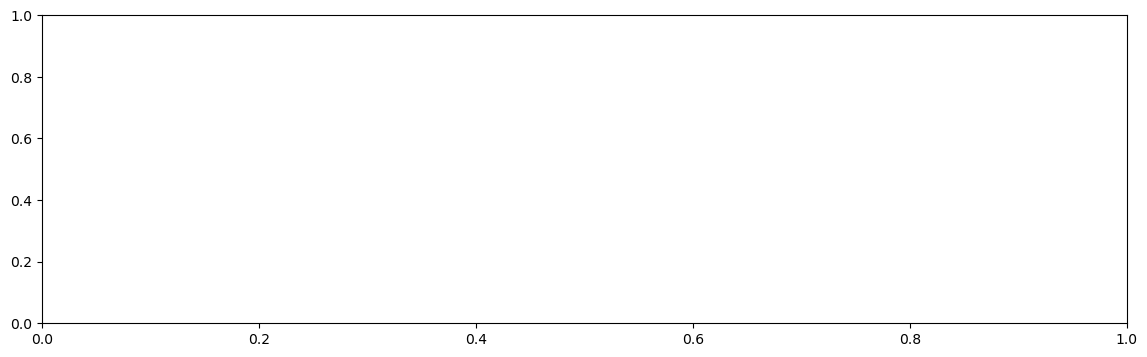

In [39]:
fig, ax = plt.subplots(1, figsize=(14, 4))

sns.scatterplot(x='date', y='total_fine_euro', data=with_controller)
# sns.lineplot(x='date', y='total_fine_euro', data=with_controller)

for _, boi in highbois.iterrows():
    xy = (boi.date, boi.total_fine_euro)
    text = boi.shortname + '\n' + boi.country
    ax.annotate(text=text,
            xy=xy, xycoords='data',
            xytext=(-10, -10), textcoords='offset points',
            ha='right',
            fontsize='medium'
    )

ax.set(title=None, xlabel=None, ylabel ="Total Fine")
ax.set_yscale("log")
ax.yaxis.set_major_formatter('{x:,.0f} €')

## Fine Value Distribution Plots

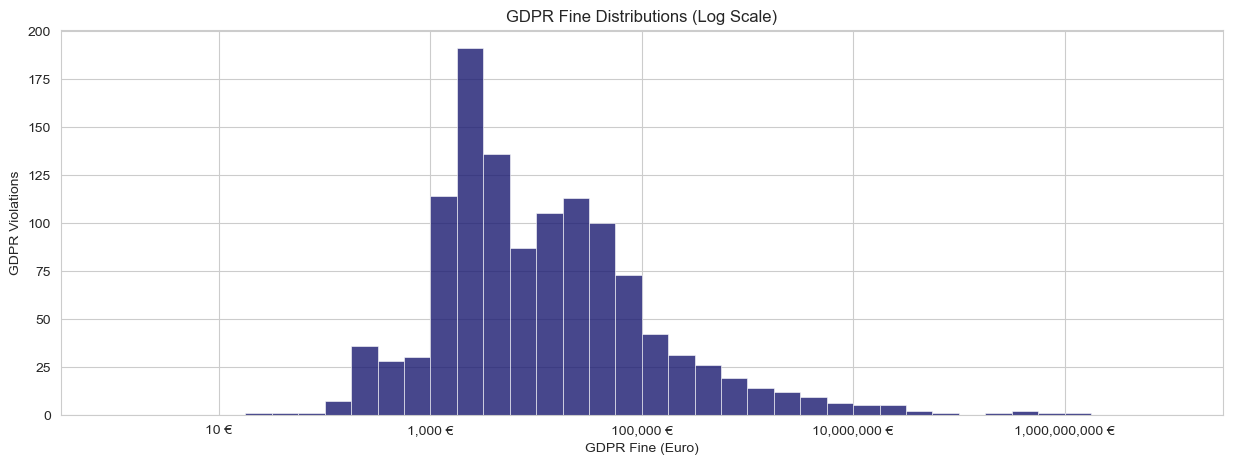

In [232]:
fig, ax = plt.subplots(figsize=(15, 5))

ax = sns.histplot(
    with_controller,
    x="total_fine_euro",
    edgecolor="white",
    linewidth=.5,
    facecolor="midnightblue",
    log_scale=True,
    binrange=(0, 10)
)


for bar in ax.patches:
    bar.set_alpha(0.8) 

ax.set(xlabel="GDPR Fine (Euro)", ylabel="GDPR Violations", title="GDPR Fine Distributions (Log Scale)")
ax.xaxis.set_major_formatter('{x:,.0f} €');

Text(0.5, 0, '')

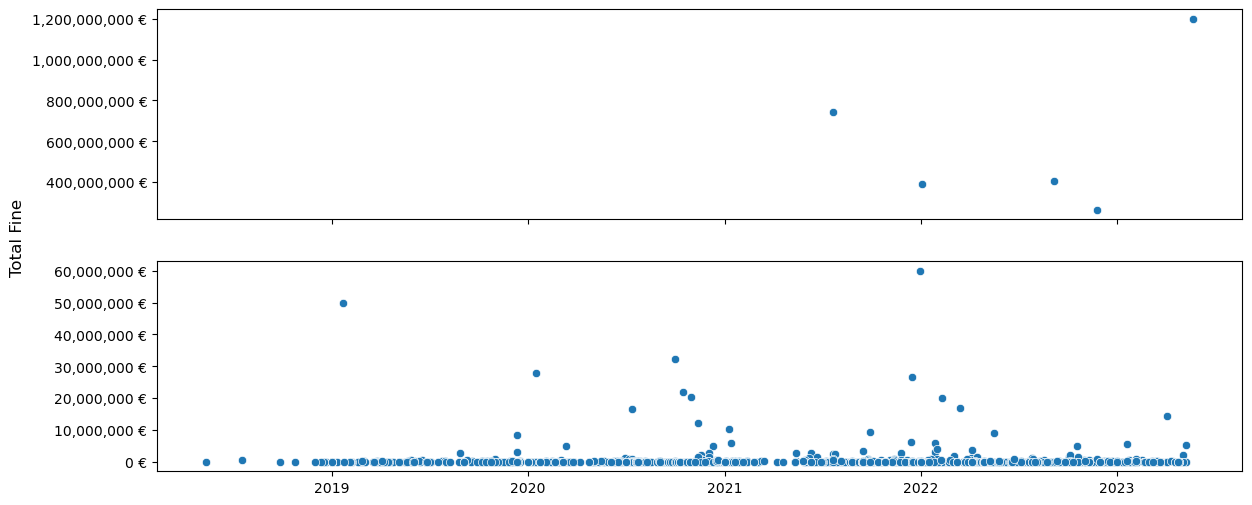

In [124]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, sharey=False)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro > 2e8'),
    ax=ax[0]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro <= 2e8'),
    ax=ax[1]
)

for axis in ax:
    axis.yaxis.set_major_formatter('{x:,.0f} €')
    axis.set_ylabel(None)
fig.supylabel('Total Fine')
plt.xlabel(None)

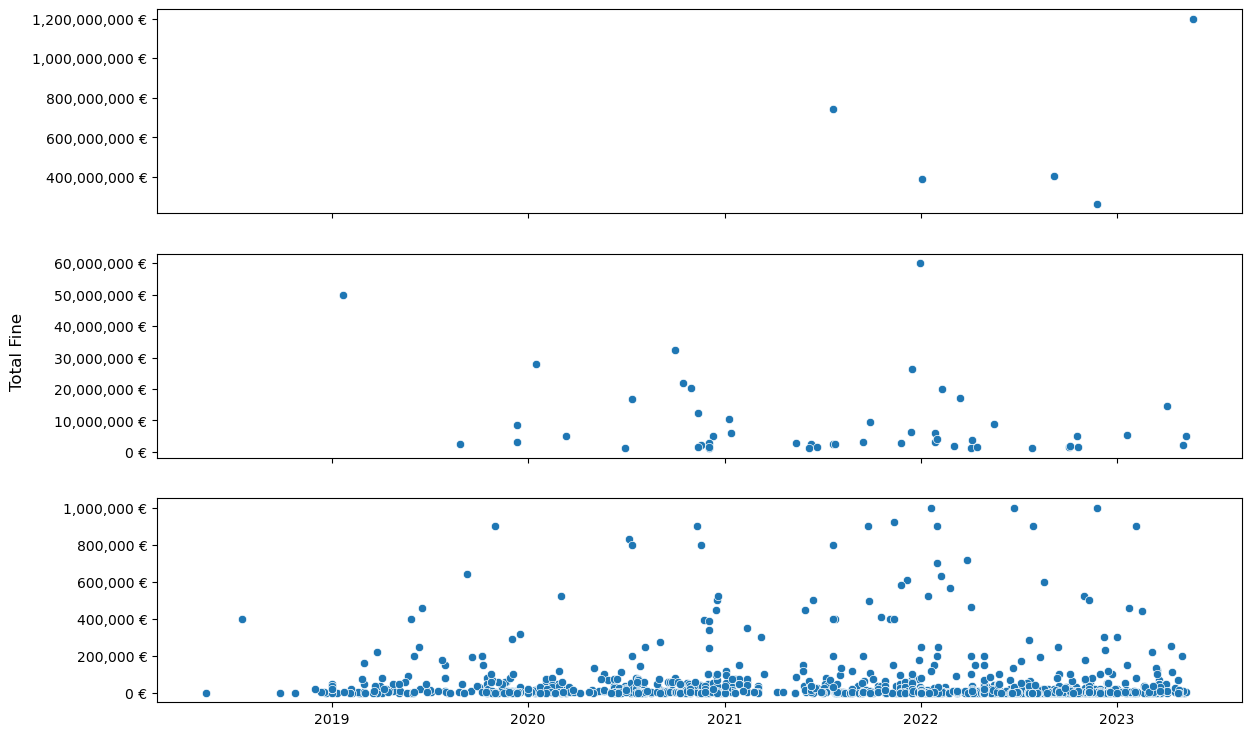

In [126]:
fig, ax = plt.subplots(3, figsize=(14, 9), sharex=True, sharey=False)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro > 2e8'),
    ax=ax[0]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('1e6 < total_fine_euro <= 2e8'),
    ax=ax[1]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro <= 1e6'),
    ax=ax[2]
)

for axis in ax:
    axis.yaxis.set_major_formatter('{x:,.0f} €')
    axis.set_ylabel(None)
    
fig.supylabel('Total Fine')
plt.xlabel(None);

## Individual Controllers

In [53]:
def strfind(series, term):
    "shorthand"
    return series.str.contains(term, case=False)

(
    with_controller
    .query('total_fine_euro > 1e6')
    .sort_values('date')
    .assign(
        shortname = lambda x: np.select(
            [strfind(x.controller, "Facebook"), strfind(x.controller, "Meta"), strfind(x.controller, "Amazon"), strfind(x.controller, "Google"),
             strfind(x.controller, "Microsoft"), strfind(x.controller, "Vodafone"), strfind(x.controller, "WhatsApp"),
             strfind(x.controller, "Clearview")],
            ["Facebook/Meta", "Facebook/Meta", "Amazon", "Google", "Microsoft", "Vodafone", "WhatsApp", "Clearview AI"],
            x.controller
        )
    )
    .groupby('shortname')
    .total_fine_euro
    .sum()
    .reset_index()
    .sort_values('total_fine_euro', ascending=False)
)


,shortname,total_fine_euro
23,Facebook/Meta,2337000000
3,Amazon,746000000
25,Google,55000000
12,Clearview AI,34200000
27,H&M Hennes & Mauritz Online Shop A.B. & Co. KG,32258708
37,TIM - Telecom Provider,27800000
21,Enel Energia S.p.A.,26500000
8,British Airways,22046000
30,"Marriott International, Inc",20450000
43,Wind Tre S.p.A.,16700000


In [158]:
top_25_fined_controllers = (
    fines_long
    .groupby('controller')
    .agg({'total_fine_euro':['sum', 'count', 'mean']})
    .droplevel(0, axis='columns')
    .reset_index()
    .sort_values('sum', ascending=False)
    .head(25)
)

## Single Violation Exploration

In [84]:
single_violations = (
    with_controller
    .assign(
        n_articles_violated = lambda x: x.loc[:, x.columns.str.startswith('article')].sum(axis='columns')
    )
    .query('n_articles_violated == 1')
    .melt(
        id_vars=['id', 'date', 'year', 'country', 'total_fine_euro', 'controller', 'n_articles_violated'],
        value_vars = with_controller.columns[with_controller.columns.str.startswith('article')].tolist(),
        var_name='article_violated',
        value_name='violated'
    )
    .loc[lambda x: x.violated == 1, ['id', 'date', 'year', 'country', 'total_fine_euro', 'article_violated']]
)

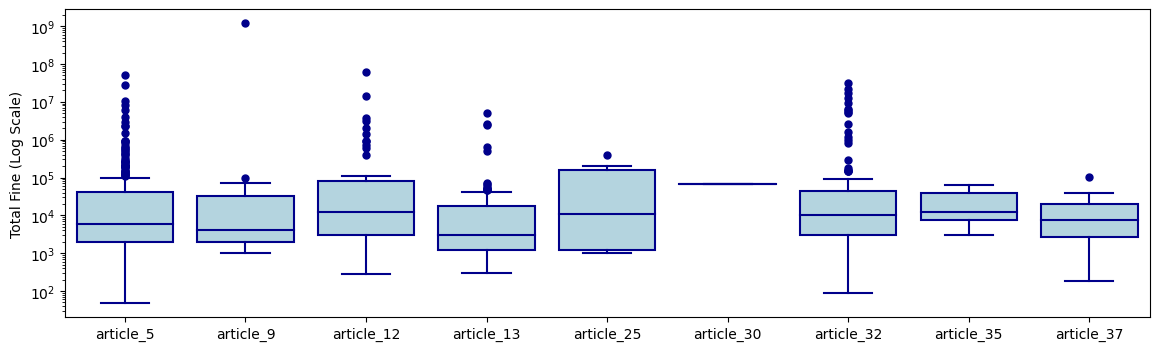

In [128]:
fig, ax = plt.subplots(1, figsize=(14,4))

sns.boxplot(
    y='total_fine_euro',
    x='article_violated',
    data=single_violations,
    ax=ax, color='lightblue',
    whiskerprops={'color':'darkblue'},
    boxprops={'edgecolor':'darkblue'},
    capprops={'color':'darkblue'},
    medianprops={'color':'darkblue'},
    flierprops={
        "marker": "o",
        "markerfacecolor':'darkblue",
                'markeredgecolor':'darkblue'
    })

ax.set(xlabel=None, ylabel="Total Fine (Log Scale)")
ax.set_yscale("log")

## Modelling

```r
library(tidymodels)

gdpr_rec <- recipe(price ~ ., data = gdpr_violations) %>%
  update_role(id, new_role = "id") %>%
  step_log(price, base = 10, offset = 1, skip = TRUE) %>%
  step_other(country, other = "Other") %>%
  step_dummy(all_nominal()) %>%
  step_zv(all_predictors())

gdpr_prep <- prep(gdpr_rec)

gdpr_prep

```

In [237]:
from sklearn.linear_model import LinearRegression

In [244]:
gdpr_model_data

,id,year,country,total_fine_euro,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,1,2019,Poland,3.972203,1,0,1,1,0,0,0,0,0,0
1,2,2019,Romania,3.397940,1,0,0,0,0,0,0,0,0,0
2,4,2019,Spain,3.903090,0,0,0,0,0,0,0,1,0,0
3,5,2019,Romania,5.176091,0,0,0,0,0,0,0,1,0,0
4,6,2019,Romania,4.301030,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1694,2022,Cyprus,3.176091,1,1,1,0,0,0,0,0,0,0
1196,1697,2023,France,6.716003,0,0,0,0,0,0,0,1,0,0
1197,1698,2020,Malta,3.301030,1,0,0,0,0,0,0,1,0,0
1198,1699,2020,Malta,3.397940,0,0,0,1,0,0,0,0,0,0


In [252]:
X = gdpr_model_data.drop(columns=["id", "total_fine_euro", "country"])
y = gdpr_model_data.total_fine_euro

In [260]:
model = LinearRegression(fit_intercept=True)
fit = model.fit(X, y)

In [321]:
coefs = pd.DataFrame(
    {"intercept" : fit.intercept_} |dict(zip(fit.feature_names_in_, fit.coef_)), index=pd.RangeIndex(start=0, stop=1)
).transpose().reset_index()

In [365]:
import statsmodels.api as sm

,year,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,2019,1,0,1,1,0,0,0,0,0,0
1,2019,1,0,0,0,0,0,0,0,0,0
2,2019,0,0,0,0,0,0,0,1,0,0
3,2019,0,0,0,0,0,0,0,1,0,0
4,2019,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1195,2022,1,1,1,0,0,0,0,0,0,0
1196,2023,0,0,0,0,0,0,0,1,0,0
1197,2020,1,0,0,0,0,0,0,1,0,0
1198,2020,0,0,0,1,0,0,0,0,0,0


In [421]:
mod = sm.OLS(y, X.assign(constant=1))
res = mod.fit()

coefs = pd.concat([res.params, res.conf_int()], axis=1)

coefs.columns = ['estimate', 'ci0', 'ci1']

coefs.reset_index(names='coef').query('coef != "constant"')

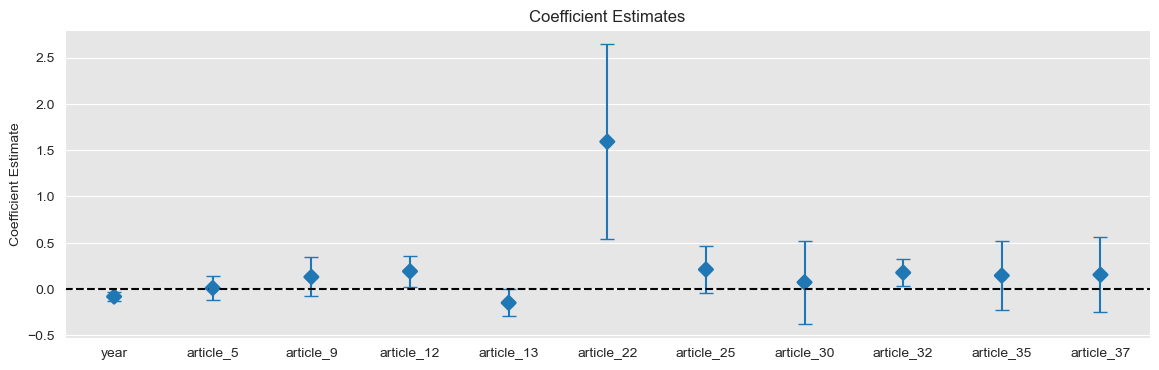

In [472]:
ci_lengths = coefs.ci1 - coefs.estimate

fig, ax = plt.subplots(figsize = (14, 4))

ax = sns.pointplot(
    x='coef', y='estimate',
    data=coefs.reset_index(names='coef').query('coef != "constant"'),
    join=False, markers="D")

ax.errorbar(
    coefs.index[:-1],
    coefs.estimate[:-1],
    yerr=ci_lengths[:-1],
    fmt='o',
    capsize=5
)

ax.axhline(y=0, color="black", linestyle="--")
ax.set(xlabel=None, ylabel="Coefficient Estimate", title="Coefficient Estimates");